https://thebinarynotes.com/video-classification-keras-convlstm/

Version History:
- v1.0.0: Original tutorial code, with I/O from boiling videos
- v1.1.0: Running code with more frames and epochs over the weekend.
- v1.1.1: Using first 10 frames to test model with new video.
- v1.1.2: Training code for PSC Bridges; added time callback to export average and total training time.
- v1.1.3: Same code as on Bridges, but adapted to run on mobile workstation.
- v1.1.6: Testing, 5 epochs, no figures

In [3]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
 
import os
import cv2
import numpy as np
import matplotlib.pyplot
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
import keras_metrics as km 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
data_dir = "videos/"
img_height , img_width = 128, 128
seq_len = 10
 
classes = ["class_0", "class_1", "class_2"]
 
#  Creating frames from videos
 
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
 
            
    return frames_list
 
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        if c != "Class 1, small":
            print(c)
            files_list = os.listdir(os.path.join(input_dir, c))
            for f in files_list:
                frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
                if len(frames) == (seq_len):
                    X.append(frames)
                    y = [0]*len(classes)
                    y[classes.index(c)] = 1
                    Y.append(y)
        else:
            pass
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [5]:
X, Y = create_data(data_dir)

class_0
class_1
Defected frame
class_2


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

In [7]:
model = Sequential()
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = False, 
                     data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(3, activation = "softmax"))
 
model.summary()
 
opt = keras.optimizers.SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

# Prepare callback for training time.
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times=[]
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start=time.time()
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

earlystop = EarlyStopping(patience=7)
mc = ModelCheckpoint('mdl_weights_v1.1.3.hdf5', save_best_only=True, monitor='val_loss', mode='min')
callbacks = [mc, time_callback]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 126, 126, 64)      154624    
_________________________________________________________________
dropout_1 (Dropout)          (None, 126, 126, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1016064)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               260112640 
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 260,268,035
Trainable params: 260,268,035
Non-trainable params: 0
________________________________________

In [8]:
history = model.fit(x = X_train, y = y_train, epochs=5, batch_size = 8 , 
                    shuffle=True, validation_split=0.2, callbacks=callbacks,
                    verbose=1)

Train on 1328 samples, validate on 332 samples
Epoch 1/5
1328/1328 [==============================] - 1697s 1s/step - loss: 0.4811 - accuracy: 0.8916 - val_loss: 0.2121 - val_accuracy: 0.9428
Epoch 2/5
1328/1328 [==============================] - 1867s 1s/step - loss: 0.1348 - accuracy: 0.9511 - val_loss: 0.0688 - val_accuracy: 0.9548
Epoch 3/5
1328/1328 [==============================] - 1934s 1s/step - loss: 0.0560 - accuracy: 0.9789 - val_loss: 0.0196 - val_accuracy: 0.9970
Epoch 4/5
1328/1328 [==============================] - 1957s 1s/step - loss: 0.0197 - accuracy: 0.9985 - val_loss: 0.0247 - val_accuracy: 0.9910
Epoch 5/5
1328/1328 [==============================] - 2003s 2s/step - loss: 0.0082 - accuracy: 0.9992 - val_loss: 0.0084 - val_accuracy: 1.0000


In [20]:
times = time_callback.times
print("Total time: ", np.sum(times))
print("Average time: ", np.sum(times)/len(times))

Total time:  9472.496505737305
Average time:  1894.499301147461


In [21]:
model.save("convlstm_v1.1.3.h5")

In [22]:
loaded_model = load_model("convlstm_v1.1.3.h5")

In [23]:
y_pred = loaded_model.predict(X_test)

In [24]:
y_pred_report = np.argmax(y_pred, axis = 1)
y_test_report = np.argmax(y_test, axis = 1)

In [25]:
print(classification_report(y_test_report, y_pred_report))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00       372
           2       1.00      1.00      1.00        22

    accuracy                           1.00       416
   macro avg       1.00      1.00      1.00       416
weighted avg       1.00      1.00      1.00       416



In [26]:
matrix = confusion_matrix(y_test_report, y_pred_report)

In [27]:
print(matrix)

[[ 22   0   0]
 [  0 372   0]
 [  0   0  22]]


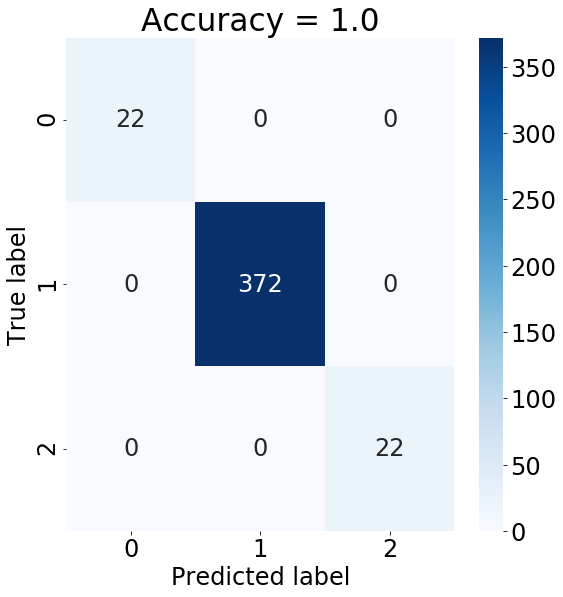

In [28]:
figure = matplotlib.pyplot.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True,cmap=matplotlib.pyplot.cm.Blues,
           annot_kws={"size": 24}, fmt='d')
matplotlib.pyplot.tight_layout()
matplotlib.rcParams.update({'font.size': 26})
matplotlib.pyplot.title("Accuracy = 1.0")
matplotlib.rcParams.update({'font.size': 24})
matplotlib.pyplot.ylabel('True label')
matplotlib.pyplot.xlabel('Predicted label')
#matplotlib.pyplot.savefig('conmatrix_convlstm_v1.1.3.png',bbox_inches='tight')
matplotlib.pyplot.show()

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [30]:
output_file = open(r"output_1.1.6.txt", "w")

output_file.write("loss\n")
for i in range(len(loss)):
    output_file.write(str(loss[i]))
    output_file.write("\n")
output_file.write("\nval_loss\n")
for i in range(len(val_loss)):
    output_file.write(str(val_loss[i]))
    output_file.write("\n")
output_file.write("\naccuracy\n")
for i in range(len(accuracy)):
    output_file.write(str(accuracy[i]))
    output_file.write("\n")
output_file.write("\nval_accuracy\n")
for i in range(len(val_accuracy)):
    output_file.write(str(val_accuracy[i]))
    output_file.write("\n")
    
output_file.close()